In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [41]:
df = pd.read_csv('./data/ep2-train.csv',
  encoding="ISO-8859-1",
  sep=";",
  decimal=",",)
print(df.head())

                                            req_text  profession
0  Sou aluna de doutorado da UFPR e pesquiso sobr...    academic
1  Gostaria de consultar a disponibilidade de cód...    academic
2  Prezados, bom dia. Procurei no site do Serpro ...  government
3  Solicito o número de matrícula do SIAP do doce...    academic
4  A Lei nº 12772/2012 regulamenta a carreira de ...    academic


            count  percent
profession                
government  18782    43.00
academic    14593    33.41
private     10303    23.59


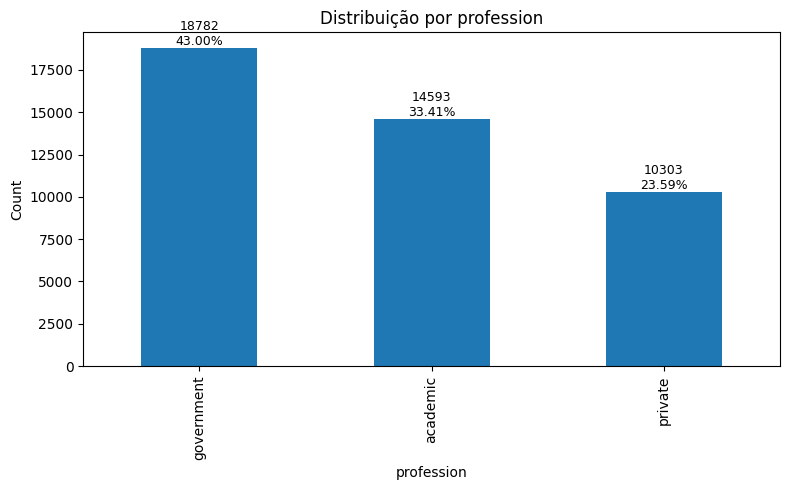

In [42]:
# Contagem e porcentagem por classe
counts = df['profession'].value_counts()
pct = df['profession'].value_counts(normalize=True) * 100
balance = pd.concat([counts, pct.round(2)], axis=1)
balance.columns = ['count', 'percent']
print(balance)

# Gráfico de barras com anotações de porcentagem
ax = counts.sort_values(ascending=False).plot(kind='bar', figsize=(8, 5), color='C0', title='Distribuição por profession')
ax.set_ylabel('Count')
total = len(df)
for p in ax.patches:
  h = p.get_height()
  ax.annotate(f'{h}\n{h/total*100:.2f}%', (p.get_x() + p.get_width() / 2, h), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [43]:
stop_pt = {
    "a", "ao", "aos", "as", "com", "da", "das", "de", "do", "dos", "e", "em",
    "no", "na", "nos", "nas", "o", "os", "para", "por", "que", "se", "um",
    "uma", "é", "foi", "ser", "são", "como"
}

def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zà-ÿ\s]', '', t)
    tokens = [w for w in t.split() if w not in stop_pt and len(w) > 2]
    return tokens

In [44]:
from collections import Counter

# aplica limpeza
df["tokens"] = df["req_text"].apply(clean_text)

# agrupa por classe
counters = {}
for label, group in df.groupby("profession"):
    all_words = [w for tokens in group["tokens"] for w in tokens]
    counters[label] = Counter(all_words).most_common(30)  # top 30

# exibe resultados
for label, words in counters.items():
    print(f"\n=== {label.upper()} ===")
    for w, c in words:
        print(f"{w:<20} {c}")


=== ACADEMIC ===
gostaria             6964
não                  5622
dados                5098
informações          5090
sobre                4242
solicito             4135
saber                3679
pela                 3446
pesquisa             3231
federal              3056
informação           2980
acesso               2970
desde                2879
agradeço             2614
qual                 2606
solicitar            2547
pelo                 2465
universidade         2434
ano                  2422
brasil               2289
número               2226
prezados             2211
concurso             2136
estou                1975
quais                1968
sou                  1908
possível             1907
boa                  1905
meio                 1857
lei                  1850

=== GOVERNMENT ===
gostaria             7436
não                  7079
solicito             6984
informações          5802
saber                5252
sobre                5205
informação           4919


In [45]:
def add_semantic_features(df):
    text = df["req_text"].str.lower()
    df["has_pesquisa"] = text.str.contains(r"\bpesquisa\b")
    df["has_universidade"] = text.str.contains(r"\buniversidade\b|\bif[a-z]*\b|\buf[a-z]*\b")
    df["has_empresa"] = text.str.contains(r"\bempresa\b")
    df["has_servidor"] = text.str.contains(r"\bservidor(es)?\b|\bfuncionário público\b")
    df["has_processo"] = text.str.contains(r"\bprocesso\b")
    df["has_contrato"] = text.str.contains(r"\bcontrato\b")
    df["has_obrigado"] = text.str.contains(r"\bobrigad[ao]\b")
    df["has_cnpj"] = text.str.contains(r"\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}")
    df["has_email_gov"] = text.str.contains(r"@.*gov\.br")
    df["has_email_edu"] = text.str.contains(r"@.*edu\.br")
    return df

In [46]:
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2)
)

# Treina o TF-IDF e gera a matriz
X_tfidf = vectorizer.fit_transform(df["req_text"])  # ou df["text"], depende do nome da sua coluna

# Adiciona features semânticas
df = add_semantic_features(df)

# Combina TF-IDF com features manuais
X_combined = hstack([
    X_tfidf,
    df[[
        "has_pesquisa", "has_universidade", "has_empresa", "has_servidor",
        "has_processo", "has_contrato", "has_obrigado", "has_cnpj",
        "has_email_gov", "has_email_edu"
    ]].astype(int).values
])

/var/folders/s0/3zl0z5gx7ll9k27wgndsh7880000gn/T/ipykernel_99157/2746421383.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_servidor"] = text.str.contains(r"\bservidor(es)?\b|\bfuncionário público\b")


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Target e features
y = df['profession']
X = X_combined  # TF-IDF + features manuais

# Holdout estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Treina Regressão Logística (one-vs-rest)
logreg = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr', random_state=42)
logreg.fit(X_train, y_train)

# Avaliação
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Acuracia: {acc:.4f}')
print(classification_report(y_test, y_pred, zero_division=0))


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Acuracia: 0.6783
              precision    recall  f1-score   support

    academic       0.68      0.66      0.67      4378
  government       0.71      0.76      0.73      5635
     private       0.60      0.56      0.58      3091

    accuracy                           0.68     13104
   macro avg       0.67      0.66      0.66     13104
weighted avg       0.68      0.68      0.68     13104



In [48]:
# Aprimoramento de features + busca de hiperparâmetros para melhorar F1
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np

# Stopwords PT (opcional)
try:
    stopwords_pt = set(stopwords.words('portuguese'))
except Exception:
    try:
        import nltk
        nltk.download('stopwords')
        stopwords_pt = set(stopwords.words('portuguese'))
    except Exception:
        stopwords_pt = None

# TF-IDF aprimorado: palavras + caracteres
vectorizer_word_adv = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    strip_accents='unicode',
    lowercase=True,
    stop_words=stopwords_pt,
    dtype=np.float32,
)
vectorizer_char_adv = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    min_df=3,
    strip_accents='unicode',
    lowercase=True,
    max_features=30000,
    dtype=np.float32,
)

texts = df['req_text'].fillna('').astype(str)
X_word_adv = vectorizer_word_adv.fit_transform(texts)
X_char_adv = vectorizer_char_adv.fit_transform(texts)
X_tfidf_adv = hstack([X_word_adv, X_char_adv])

# Features manuais como esparsas
manual_cols = [
    'has_pesquisa','has_universidade','has_empresa','has_servidor',
    'has_processo','has_contrato','has_obrigado','has_cnpj',
    'has_email_gov','has_email_edu'
]
X_manual = csr_matrix(df[manual_cols].astype(int).values)
X_enhanced = hstack([X_tfidf_adv, X_manual])

y = df['profession']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_enhanced, y, test_size=0.3, random_state=42, stratify=y
)

# Busca de hiperparâmetros focada em F1 macro
param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l2', 'l1'], 'C': [0.5, 1.0, 2.0], 'class_weight': [None, 'balanced'], 'max_iter': [1000]},
    {'solver': ['saga'], 'penalty': ['l2'], 'C': [0.5, 1.0, 2.0], 'class_weight': [None, 'balanced'], 'max_iter': [2000]},
    {'solver': ['saga'], 'penalty': ['l1'], 'C': [0.5, 1.0, 2.0], 'class_weight': [None, 'balanced'], 'max_iter': [2000]},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'l1_ratio': [0.5], 'C': [0.5, 1.0, 2.0], 'class_weight': [None, 'balanced'], 'max_iter': [2000]},
]
base_model = LogisticRegression(multi_class='auto', n_jobs=None)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True,
)
grid.fit(X_train_e, y_train_e)
print('Melhor params:', grid.best_params_)
print('CV melhor F1_macro:', f"{grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred_e = best_model.predict(X_test_e)
print('Holdout Acurácia:', f"{accuracy_score(y_test_e, y_pred_e):.4f}")
print('Holdout F1_macro:', f"{f1_score(y_test_e, y_pred_e, average='macro'):.4f}")
print(classification_report(y_test_e, y_pred_e, zero_division=0))


[nltk_data] Error loading stopwords: HTTP Error 429: Too Many Requests


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always us

[CV] END C=0.5, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.3s
[CV] END C=0.5, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.3s
[CV] END C=0.5, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.4s
[CV] END C=0.5, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.6s
[CV] END C=0.5, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.7s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always us

[CV] END C=0.5, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   7.1s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=   8.2s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  22.4s
[CV] END C=0.5, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  22.5s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always us

[CV] END C=0.5, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  23.1s
[CV] END C=0.5, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  23.6s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  24.2s
[CV] END C=0.5, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  24.3s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always us

[CV] END C=1.0, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.5s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=   8.9s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   7.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   7.8s
[CV] END C=1.0, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  23.1s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   8.1s
[CV] END C=1.0, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  24.4s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  24.6s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always us

[CV] END C=1.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  22.4s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  23.9s
[CV] END C=2.0, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=  11.3s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always us

[CV] END C=2.0, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=  10.8s
[CV] END C=2.0, class_weight=None, max_iter=1000, penalty=l1, solver=liblinear; total time=  12.0s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimato

[CV] END C=1.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  24.7s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  25.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.1s
[CV] END C=2.0, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   9.0s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=1000, penalty=l1, solver=liblinear; total time=   8.5s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  29.3s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  11.1s
[CV] END C=0.5, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  10.9s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=1000, penalty=l2, solver=liblinear; total time=  26.2s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  25.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  25.7s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  10.7s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=   9.7s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  10.4s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  12.4s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=liblinear; total time=  22.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  15.2s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  14.6s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  14.6s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  14.0s
[CV] END C=1.0, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  13.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  16.1s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  19.3s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  18.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=2000, penalty=l2, solver=saga; total time=  18.9s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  18.4s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  19.8s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=2000, penalty=l2, solver=saga; total time=  19.5s


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time= 4.6min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time= 6.1min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time= 6.8min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time= 7.9min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time= 7.8min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time= 7.9min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time= 8.8min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time=11.8min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 1.1min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time=13.4min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 1.0min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 1.0min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 1.1min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time=15.2min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time=11.0min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 1.0min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.5, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 1.1min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time=16.0min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 3.2min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 3.2min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 3.3min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 3.3min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 3.4min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1.0, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 3.4min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time=10.1min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time=21.1min
[CV] END C=2.0, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time=10.1min
[CV] END C=2.0, class_weight=None, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time=10.2min
[CV] END C=2.0, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time=10.1min
[CV] END C=2.0, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time=24.7min
[CV] END C=2.0, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 9.6min
[CV] END C=2.0, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time=24.0min
[CV] END C=2.0, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time=23.8min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=2.0, class_weight=None, max_iter=2000, penalty=l1, solver=saga; total time=29.6min
[CV] END C=2.0, class_weight=balanced, l1_ratio=0.5, max_iter=2000, penalty=elasticnet, solver=saga; total time= 7.8min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=2.0, class_weight=balanced, max_iter=2000, penalty=l1, solver=saga; total time=29.2min


/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/viniciusrosa/Documents/GitHub/ACH2118-2025-EP2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Melhor params: {'C': 2.0, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
CV melhor F1_macro: 0.6638
Holdout Acurácia: 0.6836
Holdout F1_macro: 0.6726
              precision    recall  f1-score   support

    academic       0.69      0.67      0.68      4378
  government       0.75      0.72      0.73      5635
     private       0.57      0.64      0.61      3091

    accuracy                           0.68     13104
   macro avg       0.67      0.68      0.67     13104
weighted avg       0.69      0.68      0.69     13104



In [ ]:
# LinearSVC forte com TF-IDF (palavra + caractere) e grid de C
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from scipy.sparse import hstack, csr_matrix
import numpy as np

texts = df['req_text'].fillna('').astype(str)
# vetores palavra e caractere
vec_word = TfidfVectorizer(
    ngram_range=(1, 2), min_df=3, max_df=0.9, strip_accents='unicode',
    lowercase=True, max_features=60000, dtype=np.float32
)
vec_char = TfidfVectorizer(
    analyzer='char_wb', ngram_range=(3, 5), min_df=3,
    lowercase=True, max_features=60000, dtype=np.float32
)
Xw = vec_word.fit_transform(texts)
Xc = vec_char.fit_transform(texts)
manual_cols = [
    'has_pesquisa','has_universidade','has_empresa','has_servidor',
    'has_processo','has_contrato','has_obrigado','has_cnpj',
    'has_email_gov','has_email_edu'
]
Xman = csr_matrix(df[manual_cols].astype(int).values)
X_all = hstack([Xw, Xc, Xman])
y = df['profession']
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y, test_size=0.3, stratify=y, random_state=42)

svc = LinearSVC(class_weight='balanced', max_iter=5000)
grid = GridSearchCV(
    svc,
    param_grid={'C': [0.5, 1.0, 2.0, 4.0]},
    scoring='f1_macro', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1, verbose=2, refit=True
)
grid.fit(X_tr, y_tr)
print('LinearSVC melhor params:', grid.best_params_)
print('LinearSVC CV F1_macro:', f"{grid.best_score_:.4f}")
y_pred = grid.best_estimator_.predict(X_te)
print('Holdout Acurácia:', f"{accuracy_score(y_te, y_pred):.4f}")
print('Holdout F1_macro:', f"{f1_score(y_te, y_pred, average='macro'):.4f}")
print(classification_report(y_te, y_pred, zero_division=0))


In [ ]:
# Complement Naive Bayes com CountVectorizer (palavra + caractere)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from scipy.sparse import hstack
import numpy as np

texts = df['req_text'].fillna('').astype(str)
cv_word = CountVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, strip_accents='unicode',
                         lowercase=True, max_features=120000)
cv_char = CountVectorizer(analyzer='char_wb', ngram_range=(3,5), min_df=2, lowercase=True,
                         max_features=80000)
Xw = cv_word.fit_transform(texts)
Xc = cv_char.fit_transform(texts)
X_all = hstack([Xw, Xc])
y = df['profession']
X_tr, X_te, y_tr, y_te = train_test_split(X_all, y, test_size=0.3, stratify=y, random_state=42)

cnb = ComplementNB()
grid = GridSearchCV(
    cnb, param_grid={'alpha': [0.2, 0.5, 1.0, 2.0]},
    scoring='f1_macro', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1, verbose=2, refit=True
)
grid.fit(X_tr, y_tr)
print('ComplementNB melhor params:', grid.best_params_)
print('ComplementNB CV F1_macro:', f"{grid.best_score_:.4f}")
y_pred = grid.best_estimator_.predict(X_te)
print('Holdout Acurácia:', f"{accuracy_score(y_te, y_pred):.4f}")
print('Holdout F1_macro:', f"{f1_score(y_te, y_pred, average='macro'):.4f}")
print(classification_report(y_te, y_pred, zero_division=0))


In [ ]:
# Fine-tuning BERT em PT-BR para maximizar F1 (requer GPU para ser rápido)
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

model_name = 'neuralmind/bert-base-portuguese-cased'  # alternativa: 'xlm-roberta-base'
num_labels = df['profession'].nunique()
labels = sorted(df['profession'].unique())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

texts = df['req_text'].fillna('').astype(str).tolist()
y = df['profession'].map(label2id).values
X_train_txt, X_val_txt, y_train_ids, y_val_ids = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
class TextDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        enc = self.tokenizer(text, truncation=True, max_length=self.max_length)
        return {**enc, 'labels': int(self.labels[idx])}

train_ds = TextDS(X_train_txt, y_train_ids, tokenizer)
val_ds = TextDS(X_val_txt, y_val_ids, tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels, id2label=id2label, label2id=label2id
)

# Pesos por classe para macro-F1 melhor (opcional)
class_counts = np.bincount(y)
class_weights = (1.0 / np.maximum(class_counts, 1))
class_weights = class_weights / class_weights.mean()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs.logits
        weight = torch.tensor(class_weights, dtype=torch.float, device=logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

args = TrainingArguments(
    output_dir='./results_bert_pt',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    warmup_ratio=0.1,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    logging_steps=50,
    report_to=['none'],
    fp16=torch.cuda.is_available(),
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda p: compute_metrics((p.predictions, p.label_ids)),
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)
# Relatório no holdout de validação
pred = trainer.predict(val_ds)
y_pred = pred.predictions.argmax(axis=-1)
print('Val F1_macro:', f"{f1_score(y_val_ids, y_pred, average='macro'):.4f}")
print(classification_report(y_val_ids, y_pred, target_names=[id2label[i] for i in range(num_labels)], zero_division=0))
